# Red Wine Portfolio Project

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDClassifier, LogisticRegression 
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVR, SVC

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, normalize

from sklearn.covariance import EllipticEnvelope

from statsmodels.stats.outliers_influence import variance_inflation_factor

## Notes

1. The project has be justified in terms of business
2. So, a wine maker wants to understand whether a wine is good or bad before they ship to market
3. They want a model that can tell them if a wine is good or bad based on the physical properties, to gauge how well wines will be received when they go to market
4. Justify each of our decisions [why we use a method to clean data etc]

## Business Justification

A wine maker wants to know what makes a wine good or bad using samples analysed in a lab. They want to be able to predict whether a wine is good or bad based on its physical properties (pH, etc). They therefore get a lab to analyse a load of different wines and use this data to create a dataset that includes a quality rating for each sample [these quality samples were drawn from separate studies]. They want a machine learning model drawn up that has a workable accuracy to make these predictions.

## 1. Obtain a Dataset.

We need data to work with. This dataset is located at https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009.

### 1a. Data Examination and Preparation

Before we work with the data, we'll need to make sure the rows contain valid data. To do this we'll need to first examine the data.

In [3]:
wine = pd.read_csv('winequality-red.csv')
df = pd.DataFrame(wine)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
df.rename(columns={'fixed acidity': 'fixed_acidity',
                   'volatile acidity': 'volatile_acidity',
                   'citric acid':'citric_acid',
                   'residual sugar':'residual_sugar',
                   'free sulfur dioxide':'free_sulfur_dioxide',
                   'total sulfur dioxide':'total_sulfur_dioxide'}, inplace=True)

## 2. Model Drafting

We have our x/y, features/target, data/labels sorted.

I think it's a good idea at this point to put a number of different models together. We can then measure the accuracy_score of these models against each other and get an idea of the kind of model we want to use to get the best possible prediction.

How many different types of value are in our target column ```quality```?

In [7]:
x=df.iloc[:,0:-1]
y=df.iloc[:,-1]
y.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Not too many. This is good, because it means we can use label encoding to treat it as a classification problem, not just a regression one. Let's try some different models and compare their ```accuracy_score```. 

Let's scale the data.

In [8]:
sc = StandardScaler()

In [9]:
def get_scaled_data(x, y, split, ran_state):

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split,random_state=ran_state)
    x_train = sc.fit_transform(x_train)
    x_test = sc.fit_transform(x_test)
    
    return x_train, x_test, y_train, y_test

Let's facilitate getting programmatical representations of our independent and dependent variables, also known as x and y.

In [10]:
def get_xy_vars(dataframe):
    
    # turn dataframe into x and y
    # y is last column of dataframe
    x=dataframe.iloc[:,0:-1]
    y=dataframe.iloc[:,-1]
    
    return x, y 

In [11]:
# factorise displaying linear regression model results

def print_linear_models_results(model_names_list, model_list, x_train, y_train, x_test, y_test):
    
    print('Regression Models:')
    for i in range(len(model_list)):
        print(model_names_list[i])
        print(model_list[i].score(x_train, y_train), model_list[i].score(x_test, y_test), '\n')

In [12]:
# factorise displaying classification model results

def print_classification_models_results(model_names_list, model_list, x_train, y_train, x_test, y_test):
    
    print('Classification Models:')
    for i in range(len(model_list)):
        try:
            print(model_names_list[i])
            print(model_list[i].score(x_train, y_train), model_list[i].score(x_test, y_test))
            print(f'Accuracy score: {round(accuracy_score(y_test, model_list[i].predict(x_test)) * 100, 2)}%', '\n')
        except ValueError as e:
            print('\n')

In [13]:
# we can use cross validation to prevent overfitting on our decision tree based models

def print_cross_val_model_results(model_names_list, model_list, x, y, k, x_train, y_train, x_test, y_test):

    print('Models using K-Fold Cross Validation:')
    for i in range(len(model_list)):
        kf = KFold(n_splits=k, random_state=None)
        print(model_names_list[i])
        print(cross_val_score(model_list[i], x, y, cv = kf), '\n')

In [14]:
# let's make a function that runs a given dataset through a variety of models and prints the results
# this saves us copy and pasting a million cells to get a ballpark figure of how well models handle our data

# I have parameterised the random forest models to prevent overfitting, this was done after the fact but their
# accuracy did improve

def model_draft(dataframe, split, ran_state):
    
    x, y = get_xy_vars(dataframe)
    
    x_train, x_test, y_train, y_test = get_scaled_data(x, y, 0.3, 100)
    
    # regression
    r_model = LinearRegression().fit(x_train, y_train)
    lr_model = Lasso().fit(x_train, y_train)
    rr_model = Ridge().fit(x_train, y_train)
    
    # dt based models
    dtr_model = tree.DecisionTreeRegressor().fit(x_train, y_train)
    rfr_model = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=10, random_state=100).fit(x_train, y_train)
    gbr_model = GradientBoostingRegressor(random_state=0, max_depth=1, learning_rate=0.1).fit(x_train, y_train)
    
    br_model = BaggingRegressor(estimator=RandomForestRegressor(), random_state=0).fit(x_train, y_train)
    svr_model = SVR().fit(x_train, y_train)
    
    reg_model_names = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Decision Tree Regressor',
                      'Random Forest Regressor', 'Gradient Boosting Regressor', ' Bagging Regressor', 
                       'Support Vector Regressor']
    reg_model_list = [r_model, lr_model, rr_model, dtr_model, rfr_model, gbr_model, br_model, svr_model]
    
    # classification
    log_reg_model = LogisticRegression(solver='liblinear', random_state = 42).fit(x_train, y_train)
    gn_model = GaussianNB().fit(x_train, y_train)
    
    # dt based models
    dtc_model = tree.DecisionTreeClassifier().fit(x_train, y_train)
    rfc_model = RandomForestClassifier(n_estimators=100, max_features=3, max_depth=10, random_state=100).fit(x_train, y_train)
    gbc_model = GradientBoostingClassifier(random_state=0, max_depth=1, learning_rate=0.1).fit(x_train, y_train)
    
    bc_model = BaggingRegressor(estimator=RandomForestRegressor(), random_state=0).fit(x_train, y_train)
    svc_model = SVC().fit(x_train, y_train)
    
    #classification model list
    class_model_names = ['Logistic Regression', 'Gaussian Naive Bayes', 'Decision Tree Classifier',
                      'Random Forest Classifier', 'Gradient Boosting Classifier', 'Support Vector Classifier', 
                         'Bagging Classifier']
    class_model_list = [log_reg_model, gn_model, dtc_model, rfc_model, gbc_model, svc_model, bc_model]
    
    # cross val models list
    cross_val_model_names = ['Decision Tree Regressor', 'Random Forest Regressor', 'Decision Tree Classifier',
                             'Random Forest Classifier']
    cross_val_models = [dtr_model, rfr_model, dtc_model, rfc_model]
    
    #clustering
    knn_model = KNeighborsRegressor(n_neighbors=20).fit(x_train,y_train)
    
    #print results
    print_linear_models_results(reg_model_names, reg_model_list, x_train, y_train, x_test, y_test)
    print_classification_models_results(class_model_names, class_model_list, x_train, y_train, x_test, y_test)
    print_cross_val_model_results(cross_val_model_names, cross_val_models, x, y, 5, x_train, y_train, x_test, y_test)

    print('Clustering models: ')
    print(f'K nearest neighbour model score: {knn_model.score(x_train, y_train), knn_model.score(x_test, y_test)}')

In [15]:
model_draft(df, 0.3, 100)

Regression Models:
Linear Regression
0.3789850924185246 0.30982136911078295 

Lasso Regression
0.0 -0.0003885159356080692 

Ridge Regression
0.37898481340679846 0.3098790479133421 

Decision Tree Regressor
1.0 -0.2789559543230016 

Random Forest Regressor
0.833159555424698 0.4067233205718722 

Gradient Boosting Regressor
0.43283295214705875 0.3351072299155202 

 Bagging Regressor
0.7907133599602001 0.40903759869494294 

Support Vector Regressor
0.5474468475061478 0.3770973023630122 

Classification Models:
Logistic Regression
0.6085790884718498 0.59375
Accuracy score: 59.38% 

Gaussian Naive Bayes
0.5647899910634495 0.5375
Accuracy score: 53.75% 

Decision Tree Classifier
1.0 0.55
Accuracy score: 55.0% 

Random Forest Classifier
0.968722073279714 0.6583333333333333
Accuracy score: 65.83% 

Gradient Boosting Classifier
0.644325290437891 0.6
Accuracy score: 60.0% 

Support Vector Classifier
0.675603217158177 0.6354166666666666
Accuracy score: 63.54% 

Bagging Classifier
0.790713359960200

n_estimators: @Falcon is wrong, in general the more trees the less likely the algorithm is to overfit. So try increasing this. The lower this number, the closer the model is to a decision tree, with a restricted feature set.

max_features: try reducing this number (try 30-50% of the number of features). This determines how many features each tree is randomly assigned. The smaller, the less likely to overfit, but too small will start to introduce under fitting.

max_depth: Experiment with this. This will reduce the complexity of the learned models, lowering over fitting risk. Try starting small, say 5-10, and increasing you get the best result.

min_samples_leaf: Try setting this to values greater than one. This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each.


Now we have an idea of how our models are performing, we can try and optimise them. The first method we will use is to remove outliers.

## 3. Clean Data

Let's clean our data. First we'll check for missing values.

In [16]:
df.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Our data has no missing values, since there are no null values.

Let's see how the targets - values in the ```quality``` column - are distributed.

In [17]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

As we can see, most of the rows in our data have a quality of 5.0 and 6.0. Let's structure these values in human terms so we can understand them better.

In [18]:
threes = 5
fours = 42
fives = 566
sixes = 554
sevens = 159
eights = 11

This gives us an idea of how people are likely to judge wines. They are apparently drinking variations on the Portuguese "Vinho Verde" wine. A quick google tells me that the Portugese are the biggest wine drinkers in the world per capita (https://www.therealreview.com/2022/08/04/top-ten-wine-consumers/). 

Let's make a trial dataset of the best represented data and see how it runs.

### 3a. Normalise the Dataset

In [19]:
# remove rows containing one of list of values
counts = df['quality'].value_counts()

counts = df['quality'].value_counts().tolist()
indexes = df['quality'].value_counts().index.tolist()

data_distro = [(count, idx) for count, idx in zip(counts, indexes)]
data_distro

[(681, 5), (638, 6), (199, 7), (53, 4), (18, 8), (10, 3)]

So we have 681 rows of data about wine with a quality of 5, 638 for 6, etc.

We only have 10 datapoints for wines with a quality of 3, 18 for a quality of 8, etc. This is the data we are using to train our model, so while by using it we may be able to predict a greater range of values, it doesn't have too much to go on. What's more likely is that these underrepresented targets ['quality' column in the dataframe] will interfere with our models ability to predict targets for data which it does have. So rather than broadening the scope of what our model will predict, the outlier data interferes with its ability to predict based on what it does know. 

We can't use underrepresented targets in our dataset. But we can deal with them in different ways.

Firstly, we can take every row with a quality value of less than 5 or greater than 6 and round to those numbers respectively. This is basically a way of just saying wines in those categories are either good or bad, which is fair. This might help our model to predict things.   

The second way is to simply use the best two represented targets/labels. This allows us to treat the problem as a classification one. 

Both of these approaches are valid, and we will see how either one affects our accuracy.

#### Approximate Quality to Good or Bad

Let's go through our dataset, find the rows with a quality that isn't 5 or 6, and round them to 5 or 6 respectively.

In [20]:
def approximate_quality_values(dataframe):
    
    # iterate through every row of our dataframe, round quality values to good or bad
    for (idx, row) in dataframe.iterrows():
        if row.loc['quality'] < 5:
            row.loc['quality'] = 5.0
        elif row.loc['quality'] > 6:
            row.loc['quality'] = 6.0
    return dataframe
        
inclusive_df = approximate_quality_values(df)

In [21]:
model_draft(inclusive_df, 0.3, 100)

Regression Models:
Linear Regression
0.3789850924185246 0.30982136911078295 

Lasso Regression
0.0 -0.0003885159356080692 

Ridge Regression
0.37898481340679846 0.3098790479133421 

Decision Tree Regressor
1.0 -0.1810766721044046 

Random Forest Regressor
0.833159555424698 0.4067233205718722 

Gradient Boosting Regressor
0.43283295214705875 0.3351072299155202 

 Bagging Regressor
0.7907133599602001 0.40903759869494294 

Support Vector Regressor
0.5474468475061478 0.3770973023630122 

Classification Models:
Logistic Regression
0.6085790884718498 0.59375
Accuracy score: 59.38% 

Gaussian Naive Bayes
0.5647899910634495 0.5375
Accuracy score: 53.75% 

Decision Tree Classifier
1.0 0.5625
Accuracy score: 56.25% 

Random Forest Classifier
0.968722073279714 0.6583333333333333
Accuracy score: 65.83% 

Gradient Boosting Classifier
0.644325290437891 0.6
Accuracy score: 60.0% 

Support Vector Classifier
0.675603217158177 0.6354166666666666
Accuracy score: 63.54% 

Bagging Classifier
0.790713359960

Doesn't seem to have changed much. 

### Normalising the Dataset by Representation

Let's try removing the underrepresented datapoints from our dataset.

In [22]:
fives = df.loc[df['quality'] == 5]
sixes = df.loc[df['quality'] == 6]
sevens = df.loc[df['quality'] == 7]
len(fives), len(sixes), len(sevens)

(681, 638, 199)

Let's create an empty copy of our dataset and concatenate our data subsets with it.

In [23]:
main_df = pd.DataFrame()

In [24]:
main_df = pd.concat([main_df, fives], axis=0)
main_df = pd.concat([main_df, sixes], axis=0)
main_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1592,6.3,0.51,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1593,6.8,0.62,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1595,5.9,0.55,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.51,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6


In [25]:
# reset the annoying indexes and remove them

main_df = main_df.reset_index(drop=True)

In [26]:
model_draft(main_df, 0.3, 100)

Regression Models:
Linear Regression
0.20816831884482767 0.2656257441781107 

Lasso Regression
0.0 -0.00012456158790641325 

Ridge Regression
0.20816794747125755 0.26561037940821197 

Decision Tree Regressor
1.0 -0.2748083801737351 

Random Forest Regressor
0.795365151038904 0.380832412288416 

Gradient Boosting Regressor
0.2825263736854442 0.27138039693701743 

 Bagging Regressor
0.75814462274906 0.3539921989780275 

Support Vector Regressor
0.4349856603215033 0.2849082589663292 

Classification Models:
Logistic Regression
0.7085590465872156 0.7373737373737373
Accuracy score: 73.74% 

Gaussian Naive Bayes
0.6868905742145178 0.7348484848484849
Accuracy score: 73.48% 

Decision Tree Classifier
1.0 0.6540404040404041
Accuracy score: 65.4% 

Random Forest Classifier
0.9880823401950163 0.7777777777777778
Accuracy score: 77.78% 

Gradient Boosting Classifier
0.7280606717226435 0.76010101010101
Accuracy score: 76.01% 

Support Vector Classifier
0.7562296858071506 0.7702020202020202
Accuracy 

Not bad! I think there are some broad improvements across the board. Let's try removing columns with low variance that might be cluttering our dataset and see if accuracy improves.

##### Note on Higher Train/Lower Test Scores vs Similar Train/Test Scores

Take two of our models: ```Random Forest Classifier``` and ```Support Vector Classifier```. The difference between their train and test scores are about 21 and 1.5 respectively. My intuition tells me that between these models, we should trust the SVC more because it is possible that the RFC has started to overfit.

### 3b. Feature Selection by Low Variance

In [27]:
new_df = main_df

In [28]:
new_df.var()

fixed_acidity              2.832271
volatile_acidity           0.028116
citric_acid                0.035342
residual_sugar             1.958972
chlorides                  0.002260
free_sulfur_dioxide      110.089096
total_sulfur_dioxide    1070.207728
density                    0.000003
pH                         0.023209
sulphates                  0.028001
alcohol                    0.945472
quality                    0.249924
dtype: float64

In [29]:
# remove columns with low variance, like density, maybe chlorides
new_df = new_df.drop('density', axis=1)

In [30]:
new_df.var()

fixed_acidity              2.832271
volatile_acidity           0.028116
citric_acid                0.035342
residual_sugar             1.958972
chlorides                  0.002260
free_sulfur_dioxide      110.089096
total_sulfur_dioxide    1070.207728
pH                         0.023209
sulphates                  0.028001
alcohol                    0.945472
quality                    0.249924
dtype: float64

In [31]:
model_draft(new_df, 0.3, 100)

Regression Models:
Linear Regression
0.20808139878216048 0.26513365983529835 

Lasso Regression
0.0 -0.00012456158790641325 

Ridge Regression
0.20808103977339543 0.2651113295160593 

Decision Tree Regressor
1.0 -0.23433827286663234 

Random Forest Regressor
0.7982863256196407 0.3693140262525172 

Gradient Boosting Regressor
0.28081320145809396 0.27417952351101216 

 Bagging Regressor
0.7580884186419172 0.3522085194685747 

Support Vector Regressor
0.42214145977614836 0.27085442339729415 

Classification Models:
Logistic Regression
0.7118093174431203 0.7348484848484849
Accuracy score: 73.48% 

Gaussian Naive Bayes
0.6847237269772481 0.7171717171717171
Accuracy score: 71.72% 

Decision Tree Classifier
1.0 0.7222222222222222
Accuracy score: 72.22% 

Random Forest Classifier
0.9859154929577465 0.7651515151515151
Accuracy score: 76.52% 

Gradient Boosting Classifier
0.7302275189599133 0.7424242424242424
Accuracy score: 74.24% 

Support Vector Classifier
0.7540628385698809 0.765151515151515

In [32]:
new_df = new_df.drop('chlorides', axis=1)

In [33]:
model_draft(new_df, 0.3, 100)

Regression Models:
Linear Regression
0.2071693232228472 0.26123779539514325 

Lasso Regression
0.0 -0.00012456158790641325 

Ridge Regression
0.20716894914194406 0.2612134836650175 

Decision Tree Regressor
1.0 -0.1635155850792025 

Random Forest Regressor
0.7888290685404826 0.34921940448681144 

Gradient Boosting Regressor
0.2763605253997655 0.2723921784807526 

 Bagging Regressor
0.7588493558035714 0.3431225453244763 

Support Vector Regressor
0.4074226662731837 0.2710544447190536 

Classification Models:
Logistic Regression
0.7085590465872156 0.7323232323232324
Accuracy score: 73.23% 

Gaussian Naive Bayes
0.6890574214517876 0.7095959595959596
Accuracy score: 70.96% 

Decision Tree Classifier
1.0 0.6994949494949495
Accuracy score: 69.95% 

Random Forest Classifier
0.9837486457204767 0.76010101010101
Accuracy score: 76.01% 

Gradient Boosting Classifier
0.7172264355362947 0.7247474747474747
Accuracy score: 72.47% 

Support Vector Classifier
0.752979414951246 0.76010101010101
Accuracy

I'm not sure our model has improved, but we did get a jump in accuracy after dropping a second column. Let's try dropping a third and see how our model looks.

In [34]:
new_df.var()

fixed_acidity              2.832271
volatile_acidity           0.028116
citric_acid                0.035342
residual_sugar             1.958972
free_sulfur_dioxide      110.089096
total_sulfur_dioxide    1070.207728
pH                         0.023209
sulphates                  0.028001
alcohol                    0.945472
quality                    0.249924
dtype: float64

In [35]:
new_df = new_df.drop('pH', axis=1)

In [36]:
model_draft(new_df, 0.3, 100)

Regression Models:
Linear Regression
0.20713009069066002 0.26126257010815446 

Lasso Regression
0.0 -0.00012456158790641325 

Ridge Regression
0.20712972005857988 0.26123826159370944 

Decision Tree Regressor
1.0 -0.1635155850792025 

Random Forest Regressor
0.7845013233916789 0.3442038384392614 

Gradient Boosting Regressor
0.2748475325292423 0.27333864943805086 

 Bagging Regressor
0.7570091679276314 0.34606328543689346 

Support Vector Regressor
0.37019456907529935 0.2990946684256358 

Classification Models:
Logistic Regression
0.7107258938244854 0.7348484848484849
Accuracy score: 73.48% 

Gaussian Naive Bayes
0.6847237269772481 0.7070707070707071
Accuracy score: 70.71% 

Decision Tree Classifier
1.0 0.6818181818181818
Accuracy score: 68.18% 

Random Forest Classifier
0.9837486457204767 0.7575757575757576
Accuracy score: 75.76% 

Gradient Boosting Classifier
0.7226435536294691 0.7247474747474747
Accuracy score: 72.47% 

Support Vector Classifier
0.7464788732394366 0.7575757575757576

### Was Low Variance Filter a Suitable Feature Reduction Technique?

No. We'll go back to using ```main_df``` and try some other stuff.

### 3b.  Remove Outliers

We've trimmed our dataset down to the two best represented values in the ```quality``` column. Let's put an x and y together and see if it performs better than earlier!

In [40]:
# let's calculate the mean of each column

def get_column_means(dataframe):
    means = []
    for i in range(len(df.columns)):
        means.append(np.mean(dataframe.iloc[:, i]))
    return np.array(means)
        
print(get_column_means(main_df))

[ 8.25428355  0.53855951  0.25826384  2.50386657  0.08897271 16.36846096
 48.94692949  0.99686731  3.31129644  0.64726308 10.2527167   5.48369977]


In [41]:
# and its standard deviation

def get_column_deviations(dataframe):
    deviations = []
    for i in range(len(df.columns)):
        deviations.append(np.std(dataframe.iloc[:, i]))
    return np.array(deviations)
        
print(get_column_deviations(main_df))

[1.68229718e+00 1.67615424e-01 1.87923339e-01 1.39910219e+00
 4.75196222e-02 1.04883570e+01 3.27016261e+01 1.81446553e-03
 1.52286797e-01 1.67270420e-01 9.71985008e-01 4.99734232e-01]


In [42]:
def get_inliers(dataframe, within_std, col_names_to_exclude=[None]):
    
    # no_of_std is the number of standard deviations a cell value can lie within before the row is counted as an outlier.
    # for instance, dataframe = [1, 2, 2, 4]
    # mean is 9/4 = 2.25
    # deviation is numerical distance from the mean
    # standard deviation is the sum of the square root of a collections deviations from the mean
    # deviations from 1 standard deviation are: 1.25, .25, .25, 1.75
    # standard deviations squares these and sums them
    
    # within_std can take a float
    # col_names_to_exclude is presumably a list of targets
    
    # get means and deviations 
    means = get_column_means(dataframe)
    deviations = get_column_deviations(dataframe)
    
    inliers_df = pd.DataFrame(columns=dataframe.columns)
    outliers_df = pd.DataFrame(columns=dataframe.columns)
    
    # iterate through every row of our dataframe
    for row in dataframe.iterrows():
        
        # we then iterate through each column of the row
        # we could use for i in range(len(means)) but it's less explicit
        
        for i in range(len(dataframe.columns)):
            
            # skip current column if its in list of column names to exclude
            if dataframe.columns[i] in col_names_to_exclude:
                break
            
            inlier = True
            
            # according to the sigma 3 rule, 95% of datapoints fall within first two standard deviations
            # we therefore create upper and lower bounds representing column mean minus or plus 2 * std
            lower_bound = means[i] - within_std * deviations[i]
            upper_bound = means[i] + within_std * deviations[i]
            
            # get value of current cell
            # row[0] contains the index, row[1] contains the data... we can access each row cell with row[1][i]
            cell_value = row[1][i]
            
            if cell_value >= lower_bound and cell_value <= upper_bound:
                continue
            else:
                inlier = False
                break
        
        # convert row to dataframe, retain structure
        row_as_df = pd.DataFrame(row[1]).transpose()
        
        if inlier:
            inliers_df = pd.concat([inliers_df, row_as_df], axis=0)
        if not inlier:
            outliers_df = pd.concat([outliers_df, row_as_df], axis=0)
        
    return inliers_df, outliers_df

Let's put our refined dataset to the test and see what it can predict!

In [60]:
deviations = [1.5, 2, 2.5]

for deviation in deviations:
    
    print('\nCurrent standard deviation is: ', str(deviation), '\n')
    inliers, outliers = get_inliers(main_df, deviation)
    inliers = inliers.astype('float64')
    model_draft(inliers, 0.3, 100)


Current standard deviation is:  1.5 

Regression Models:
Linear Regression
0.22344602536904667 0.1418387329178088 

Lasso Regression
0.0 -0.007687199687644197 

Ridge Regression
0.22343714125103986 0.14291963182531553 

Decision Tree Regressor
1.0 -0.26001465559355164 

Random Forest Regressor
0.8554149629695549 0.26395916964303534 

Gradient Boosting Regressor
0.3013307187038423 0.15865336803982588 

 Bagging Regressor
0.7330245237493229 0.21276048339032738 

Support Vector Regressor
0.5835738259527643 0.057053556238053416 

Classification Models:
Logistic Regression
0.6919431279620853 0.6740331491712708
Accuracy score: 67.4% 

Gaussian Naive Bayes
0.6800947867298578 0.7071823204419889
Accuracy score: 70.72% 

Decision Tree Classifier
1.0 0.7071823204419889
Accuracy score: 70.72% 

Random Forest Classifier
1.0 0.7292817679558011
Accuracy score: 72.93% 

Gradient Boosting Classifier
0.7109004739336493 0.6850828729281768
Accuracy score: 68.51% 

Support Vector Classifier
0.808056872037

Doesn't seem to increase accuracy, but worth a try.

## 4. Data Exploration

Now we've cleaned our data and removed outliers - including rows containing underrepesented data values - we can explore the data. First let's look for **colinearities**. Colinearities occur where two or more predictor variables/features are closely correlated. This can make it difficult to predict one value from the other. Though they are mostly a problem in regression models, they can also impact our ability to understand classification ones. Our strongest model out the gate is a ```logistic regression``` one, and that is the one I want to stick with, so will try to find and remove colinearities.

### 4a. Calculate Colinearities using Variance Inflation Factor

Variance Inflation Factor is a metric that tells us how closely correlated features are. The higher the VIF, the higher the correlation. It tells us how much a variable is contributing to the standard error in regression-based calculations. When there are big multicolinearity issues, VIF values will be big to reflect that. 

When we have identified these values, we can eliminate or combine collinear variables to solve multicolinearity.

Let's take a look at our dataset's VIF values.

In [45]:
vif_df = main_df.drop(['quality'], axis=1)

In [46]:
vif_df = main_df

In [47]:
def get_vif(dataframe):
    for i in range(len(dataframe.columns)):
        print(dataframe.columns[i], variance_inflation_factor(dataframe, i))

get_vif(main_df), print("\n"), get_vif(vif_df)

# do i include target column when inspecting VIF?

fixed_acidity 74.44453944963715
volatile_acidity 19.156420361962585
citric_acid 8.336203370140614
residual_sugar 4.6464684441807425
chlorides 6.516765283007158
free_sulfur_dioxide 6.956396879041938
total_sulfur_dioxide 7.3469064528397245
density 1557.7948984498641
pH 1053.794558621151
sulphates 21.274284711569145
alcohol 149.5585721589109
quality 156.94464591107752


fixed_acidity 74.44453944963715
volatile_acidity 19.156420361962585
citric_acid 8.336203370140614
residual_sugar 4.6464684441807425
chlorides 6.516765283007158
free_sulfur_dioxide 6.956396879041938
total_sulfur_dioxide 7.3469064528397245
density 1557.7948984498641
pH 1053.794558621151
sulphates 21.274284711569145
alcohol 149.5585721589109
quality 156.94464591107752


(None, None, None)

Let's take out the column with the highest VIF and see how that impacts the VIF of the rest of the columns:

In [48]:
vif_df = vif_df.drop('density', axis=1)
get_vif(new_df)

fixed_acidity 42.65211348899319
volatile_acidity 15.956597613365366
citric_acid 7.719417405783541
residual_sugar 4.634718671213499
free_sulfur_dioxide 6.879821464065353
total_sulfur_dioxide 6.5709225951414965
sulphates 17.599482866630204
alcohol 101.69482249014206
quality 115.82391191281138


In [49]:
model_draft(vif_df, 0.3, 100)

Regression Models:
Linear Regression
0.20808139878216048 0.26513365983529835 

Lasso Regression
0.0 -0.00012456158790641325 

Ridge Regression
0.20808103977339543 0.2651113295160593 

Decision Tree Regressor
1.0 -0.21410321921308095 

Random Forest Regressor
0.7982863256196407 0.3693140262525172 

Gradient Boosting Regressor
0.28081320145809396 0.27417952351101216 

 Bagging Regressor
0.7580884186419172 0.3522085194685747 

Support Vector Regressor
0.42214145977614836 0.27085442339729415 

Classification Models:
Logistic Regression
0.7118093174431203 0.7348484848484849
Accuracy score: 73.48% 

Gaussian Naive Bayes
0.6847237269772481 0.7171717171717171
Accuracy score: 71.72% 

Decision Tree Classifier
1.0 0.7095959595959596
Accuracy score: 70.96% 

Random Forest Classifier
0.9859154929577465 0.7651515151515151
Accuracy score: 76.52% 

Gradient Boosting Classifier
0.7302275189599133 0.7424242424242424
Accuracy score: 74.24% 

Support Vector Classifier
0.7540628385698809 0.765151515151515

In [50]:
get_vif(vif_df)

fixed_acidity 43.016875726028154
volatile_acidity 19.112206480769228
citric_acid 8.3056340650316
residual_sugar 4.64622550939642
chlorides 5.973098817718006
free_sulfur_dioxide 6.884483022134156
total_sulfur_dioxide 6.778606527448602
pH 207.1648211686496
sulphates 21.26974152544324
alcohol 148.93998084726744
quality 148.23924502397404


Wow! That appears to have helped a lot in regards to VIF (not so much accuracy). Let's try another column

In [51]:
vif_df = vif_df.drop('pH', axis=1)
get_vif(vif_df)

fixed_acidity 42.93627742000652
volatile_acidity 17.385369456428226
citric_acid 8.168478824722092
residual_sugar 4.646129673053951
chlorides 5.94768284102608
free_sulfur_dioxide 6.882905539366496
total_sulfur_dioxide 6.581635620973742
sulphates 21.2216518536195
alcohol 103.8410408097723
quality 116.1191771779256


In [52]:
model_draft(vif_df, 0.3, 100)

Regression Models:
Linear Regression
0.2080808635460426 0.26516001228119723 

Lasso Regression
0.0 -0.00012456158790641325 

Ridge Regression
0.20808050818568713 0.26513975743739415 

Decision Tree Regressor
1.0 -0.14328053142565134 

Random Forest Regressor
0.7874035513584579 0.36842546874349247 

Gradient Boosting Regressor
0.2791950318933031 0.27410050359015725 

 Bagging Regressor
0.7575499166729323 0.35255832284108357 

Support Vector Regressor
0.37969146733172476 0.29322929981067347 

Classification Models:
Logistic Regression
0.7118093174431203 0.7373737373737373
Accuracy score: 73.74% 

Gaussian Naive Bayes
0.6868905742145178 0.7196969696969697
Accuracy score: 71.97% 

Decision Tree Classifier
1.0 0.7070707070707071
Accuracy score: 70.71% 

Random Forest Classifier
0.9859154929577465 0.7702020202020202
Accuracy score: 77.02% 

Gradient Boosting Classifier
0.7356446370530878 0.7373737373737373
Accuracy score: 73.74% 

Support Vector Classifier
0.7518959913326111 0.76262626262626

#### Has Removing Columns with High Variance Inflation Factor Helped?

No. Let's go back to using ```main_df``` and try to edit or combine columns with a high VIF in order to get a better result.

### 4b. Data Exploration using Graphs

In [53]:
corr = main_df.corr()

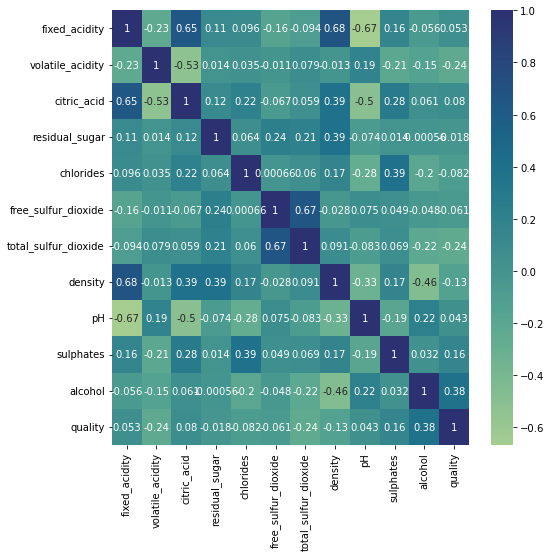

In [54]:
plt.subplots(figsize=(8,8))
sns.heatmap(corr,cmap= 'crest',annot=True)
plt.show()

This is a heatmap of **feature colinearity** containing values between -1 (directly negatively correlated, 0 (not correlated) and 1 (directly correlated). High feature correlation can introduce noise to a dataset. When we have features that are highly correlated, we have a number of options:

1. Change them
2. Combine them
3. Remove them

Moderate correlation starts to appear at values of 0.6~, so as we can see, we have a number of moderately correlated features. Fixed acidity is moderately correlated to 3 other features, ```citric_acid```, ```density``` and ```pH```.

Let's remove ```fixed_acidity``` and see if it has any bearing on our accuracy.

In [55]:
data_exp_df = main_df.drop(['fixed_acidity'], axis=1)

In [56]:
model_draft(data_exp_df, 3.0, 100)

Regression Models:
Linear Regression
0.20699212005921097 0.2651619226776418 

Lasso Regression
0.0 -0.00012456158790641325 

Ridge Regression
0.2069916246999759 0.2651646991051928 

Decision Tree Regressor
1.0 -0.24445579969340803 

Random Forest Regressor
0.8050116581320969 0.36298490246568904 

Gradient Boosting Regressor
0.279670876635129 0.2689582524109192 

 Bagging Regressor
0.7564340886137217 0.35481100030659185 

Support Vector Regressor
0.4255736881945782 0.2893234066138053 

Classification Models:
Logistic Regression
0.71397616468039 0.7373737373737373
Accuracy score: 73.74% 

Gaussian Naive Bayes
0.685807150595883 0.7424242424242424
Accuracy score: 74.24% 

Decision Tree Classifier
1.0 0.6540404040404041
Accuracy score: 65.4% 

Random Forest Classifier
0.9859154929577465 0.7676767676767676
Accuracy score: 76.77% 

Gradient Boosting Classifier
0.7258938244853738 0.7550505050505051
Accuracy score: 75.51% 

Support Vector Classifier
0.752979414951246 0.7550505050505051
Accuracy

Doesn't appear to have helped! Let's explore some more graphs:

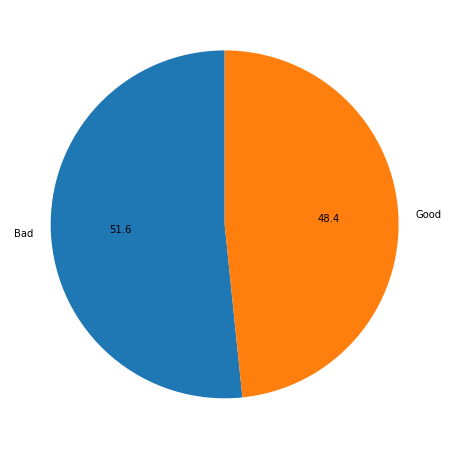

In [68]:
plt.figure(figsize = (8,8))
plt.pie(main_df['quality'].value_counts(), startangle = 90, autopct = '%.1f', labels = ['Bad', 'Good'], shadow = False)
plt.show()

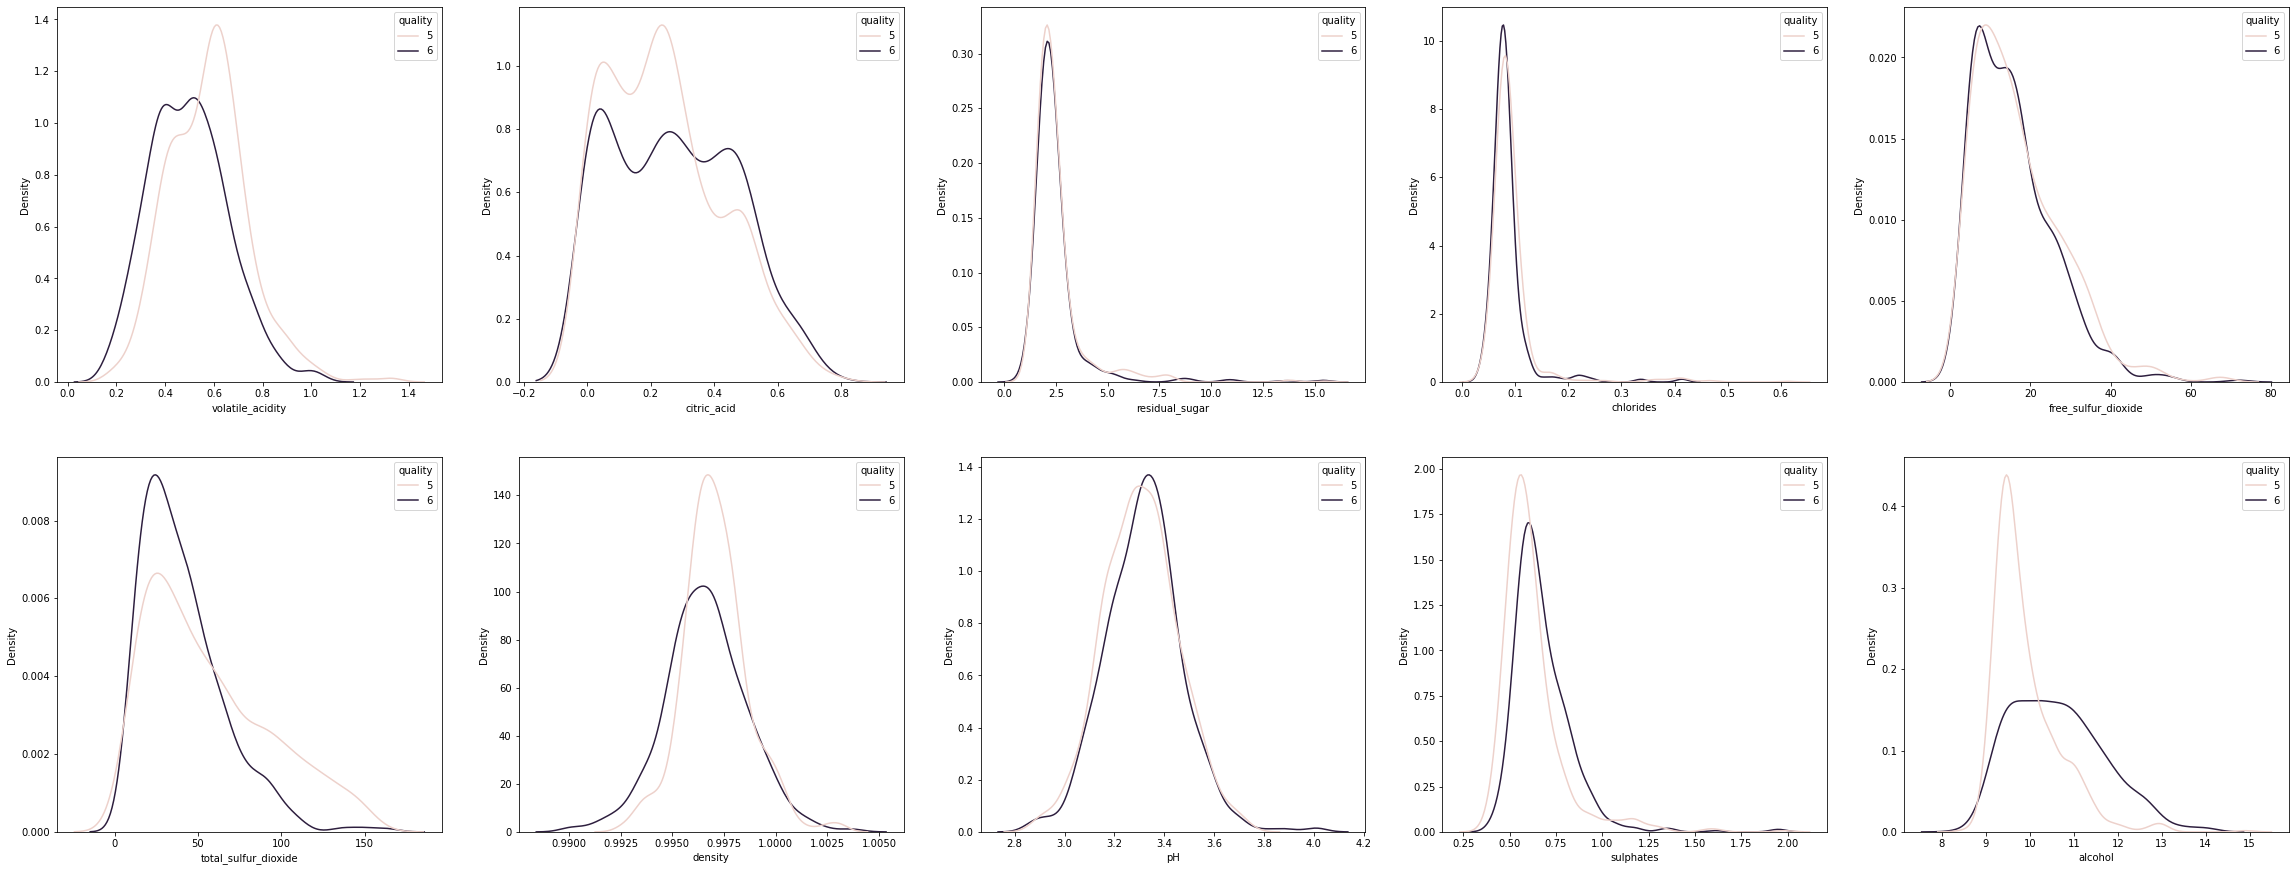

In [85]:
# let's find out how different feature values relate to the classes we're predicting

plt.figure(figsize=(40,40))
for i in range(1,len(main_df.columns)-1):
    plt.subplot(5,5,i)
    sns.kdeplot(x=main_df[main_df.columns[i]],hue=main_df['quality'])